In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import MultiTaskDataset
import evaluation

In [2]:
def plot_AAPD(predictions, target, title):
    #predictions = predictions.detach().cpu().numpy()
    #target = target.detach().cpu().numpy()
    
    aapd= abs(predictions - target) / abs(target)
    column_means = np.mean(aapd, axis=0)
    column_stddev = np.std(aapd, axis=0)
    print(column_means)
    print(np.mean(column_means))
    
    plt.figure(figsize=(10, 6))

    plt.plot(np.arange(20), np.zeros(20), label='0')
    #plt.plot(np.arange(20), np.full(20, 0.1), label='0.1')
    plt.errorbar(range(aapd.shape[1]), column_means, yerr=column_stddev, fmt='o', capsize=5, label='Mean ± StdDev')

    plt.title(title)
    #plt.ylim([-1, 1])
    #plt.yscale('log')
    plt.xlabel('Bin Index')
    plt.ylabel('<|(predictions - labels) / labels|>', fontsize=12)
    plt.legend()
    plt.savefig(f'{title}.pdf')

    plt.show()

In [3]:
input_data = np.load('inputs.npy').astype(np.float32)
output_data = np.load('outputs.npy').astype(np.float32)

train_int, dev_int, train_out, dev_out = train_test_split(input_data, output_data, test_size=0.2, random_state=42)

train_out1 = train_out[:, 0, :]
train_out2 = train_out[:, 1, :]
train_out3 = train_out[:, 2, :]

dev_out1 = dev_out[:, 0, :]
dev_out2 = dev_out[:, 1, :]
dev_out3 = dev_out[:, 2, :]

In [4]:
dm1 = np.load('Bolplanck_DM_xi.npy').astype(np.float32)
train_out1_dm = train_out1 / dm1
dev_out1_dm = dev_out1 / dm1

train_out2_dm_og = train_out2 / dm1
dev_out2_dm_og = dev_out2 / dm1

train_out3_dm_og = train_out3 / dm1
dev_out3_dm_og = dev_out3 / dm1

In [5]:
indices = np.any(dev_out1_dm > 100, axis=1)
rows_to_delete_dev = np.where(indices)[0]
print(rows_to_delete_dev.shape)

(502,)


In [6]:
indices = np.any(train_out1_dm > 100, axis=1)
rows_to_delete_train = np.where(indices)[0]
print(rows_to_delete_train.shape)

(1881,)


In [7]:
train_out1 = np.delete(train_out1, rows_to_delete_train, axis=0)
dev_out1 = np.delete(dev_out1, rows_to_delete_dev, axis=0)

train_out2 = np.delete(train_out2, rows_to_delete_train, axis=0)
dev_out2 = np.delete(dev_out2, rows_to_delete_dev, axis=0)

train_out3 = np.delete(train_out3, rows_to_delete_train, axis=0)
dev_out3 = np.delete(dev_out3, rows_to_delete_dev, axis=0)

In [8]:
train_out1_dm = np.delete(train_out1_dm, rows_to_delete_train, axis=0)
dev_out1_dm = np.delete(dev_out1_dm, rows_to_delete_dev, axis=0)

train_out2_dm_og = np.delete(train_out2_dm_og, rows_to_delete_train, axis=0)
dev_out2_dm_og = np.delete(dev_out2_dm_og, rows_to_delete_dev, axis=0)

train_out3_dm_og = np.delete(train_out3_dm_og, rows_to_delete_train, axis=0)
dev_out3_dm_og = np.delete(dev_out3_dm_og, rows_to_delete_dev, axis=0)

In [9]:
def column_wise_r(A, B):
    r = np.zeros(A.shape[1])
    for col in range(A.shape[1]):
        r[col] = np.mean(abs(A[:, col] / B[:, col]))
        r[col] = np.sqrt(r[col])
    return r

In [10]:
r12 = column_wise_r(train_out1_dm, train_out2_dm_og).astype(np.float32)
print(r12)
r13 = column_wise_r(train_out1_dm, train_out3_dm_og).astype(np.float32)
print(r13)

[897.1982   673.00494  679.99384  562.6633   420.83118  361.24155
 349.27252  317.8694   194.38054  127.01312   90.09065   89.07621
  50.156803  50.599228  49.930668  45.284874  45.746452  41.250507
  32.769413  27.539112]
[1074.1969   1043.1628    989.0476   1076.9342    840.737     807.39703
 1111.9567    998.92377   988.8078    540.1072    461.9973    373.55136
  232.99428   146.7894    202.56018   181.88087   145.0774    176.11647
  128.44656   113.359924]


In [11]:
train_out2_dm = train_out2_dm_og * r12 * 5
train_out3_dm = train_out3_dm_og * r13

In [12]:
dev_out2_dm = dev_out2_dm_og * r12 * 5
dev_out3_dm = dev_out3_dm_og * r13

In [13]:
train_int = np.delete(train_int, rows_to_delete_train, axis=0)
dev_int = np.delete(dev_int, rows_to_delete_dev, axis=0)

In [14]:
train_dataset = MultiTaskDataset.MultiTaskDataset(train_int, train_out1_dm, train_out2_dm, train_out3_dm)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

dev_dataset = MultiTaskDataset.MultiTaskDataset(dev_int, dev_out1_dm, dev_out2_dm, dev_out3_dm)
dev_dataloader = DataLoader(dev_dataset)

In [15]:
class FCED(nn.Module):
    def __init__(self, input_dim=7, hidden_dim=128, bottleneck_dim=64, output_dim=20):
        super(FCED, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.BatchNorm1d(hidden_dim),
#             nn.LeakyReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.BatchNorm1d(hidden_dim),
#             nn.LeakyReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.BatchNorm1d(hidden_dim),
#             nn.LeakyReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.BatchNorm1d(hidden_dim),
#             nn.LeakyReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.BatchNorm1d(hidden_dim),
#             nn.LeakyReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, bottleneck_dim),
            nn.ReLU(),
            nn.Linear(bottleneck_dim, bottleneck_dim),
            nn.ReLU(),
            nn.Linear(bottleneck_dim, bottleneck_dim),
            nn.ReLU(),
            nn.Linear(bottleneck_dim, output_dim)
        )
        
        self.decoder1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=bottleneck_dim, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=bottleneck_dim, out_channels=bottleneck_dim, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
#             nn.Conv1d(in_channels=bottleneck_dim, out_channels=bottleneck_dim, kernel_size=3, stride=1, padding=1),
#             nn.LeakyReLU(),
#             nn.Conv1d(in_channels=bottleneck_dim, out_channels=bottleneck_dim, kernel_size=3, stride=1, padding=1),
#             nn.LeakyReLU(),
            nn.Conv1d(in_channels=bottleneck_dim, out_channels=output_dim, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(output_dim*hidden_dim, output_dim)
        )
        
        self.decoder2 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=bottleneck_dim, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=bottleneck_dim, out_channels=bottleneck_dim, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=bottleneck_dim, out_channels=bottleneck_dim, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
#             nn.Conv1d(in_channels=bottleneck_dim, out_channels=bottleneck_dim, kernel_size=3, stride=1, padding=1),
#             nn.LeakyReLU(),
            nn.Conv1d(in_channels=bottleneck_dim, out_channels=output_dim, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(output_dim*hidden_dim, output_dim)
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        task1 = self.fc(encoded)
        
        encoded = encoded.view(encoded.size(0), 1, -1)
        
        task2 = self.decoder1(encoded)
        task3 = self.decoder2(encoded)
        
        outputs = torch.stack((task1, task2, task3), dim=1)
        
        return outputs

In [16]:
best_model_mul = FCED()
best_model_mul.load_state_dict(torch.load('mul_FCED.pth', map_location=torch.device('mps')))
best_model_mul.eval()
outputs_train = best_model_mul(torch.tensor(train_int))
outputs_dev = best_model_mul(torch.tensor(dev_int))

In [16]:
print(outputs_train.shape)

torch.Size([91225, 3, 20])


In [17]:
outputs_train = outputs_train.detach().cpu().numpy()
outputs_dev = outputs_dev.detach().cpu().numpy()

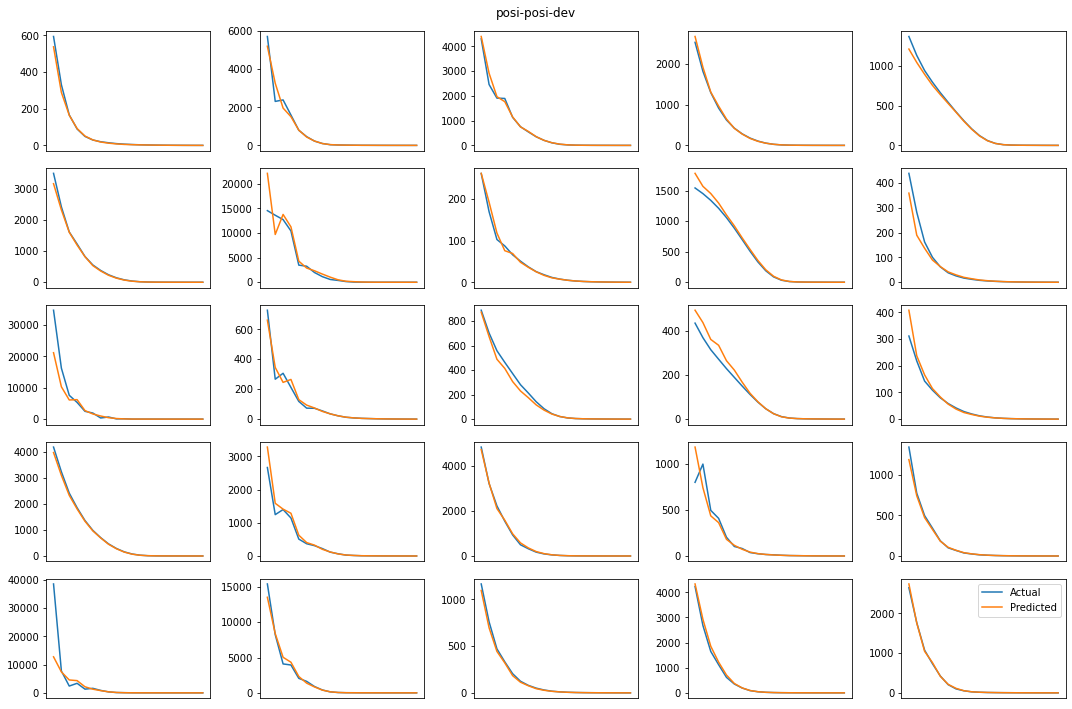

In [18]:
evaluation.plot_55(outputs_dev[:, 0, :]*dm1, dev_out1, 'posi-posi-dev')

[0.2635968  0.21614876 0.18731204 0.15568525 0.16098337 0.14659293
 0.13092777 0.12488586 0.11921582 0.11794154 0.11377423 0.10556755
 0.09078487 0.08095767 0.06324235 0.06106521 0.05716617 0.05421427
 0.05445567 0.05569471]
0.11801064


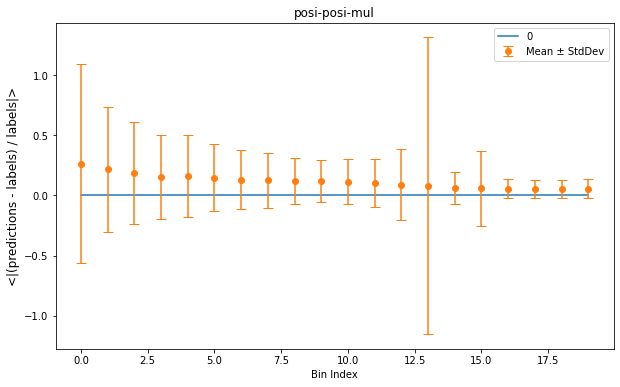

In [19]:
plot_AAPD(outputs_dev[:, 0, :]*dm1, dev_out1, 'posi-posi-mul')

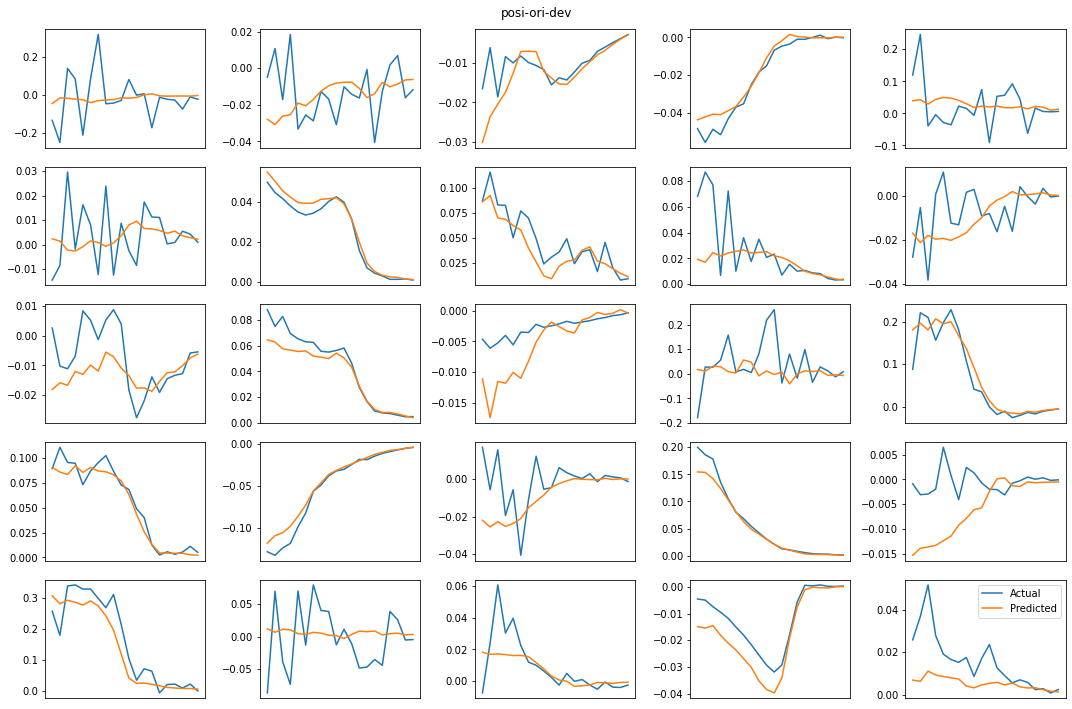

In [21]:
prediction2_dev = outputs_dev[:, 1, :]*dm1
prediction2_dev /= (r12 * 5)
evaluation.plot_55(prediction2_dev, dev_out2, 'posi-ori-dev')

[3.2519622 2.0794384 2.1316547 2.282099  1.7152528 7.011691  1.1971074
 1.6593294 2.0771682 2.9868078 1.4422107 5.4656177 1.7682834 1.5982265
 1.665937  2.3507206 3.6511786 1.6765811 2.5623293 1.830588 ]
2.5202096


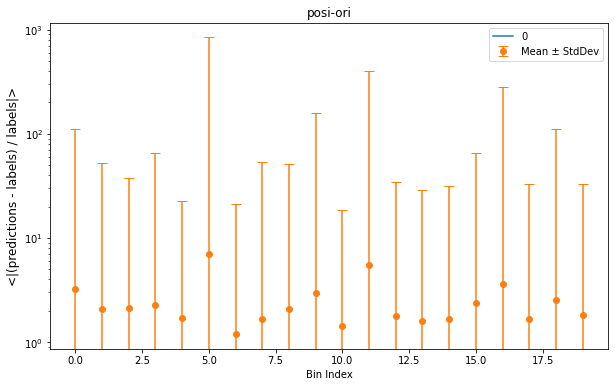

In [28]:
plot_AAPD(prediction2_dev, dev_out2, 'posi-ori')

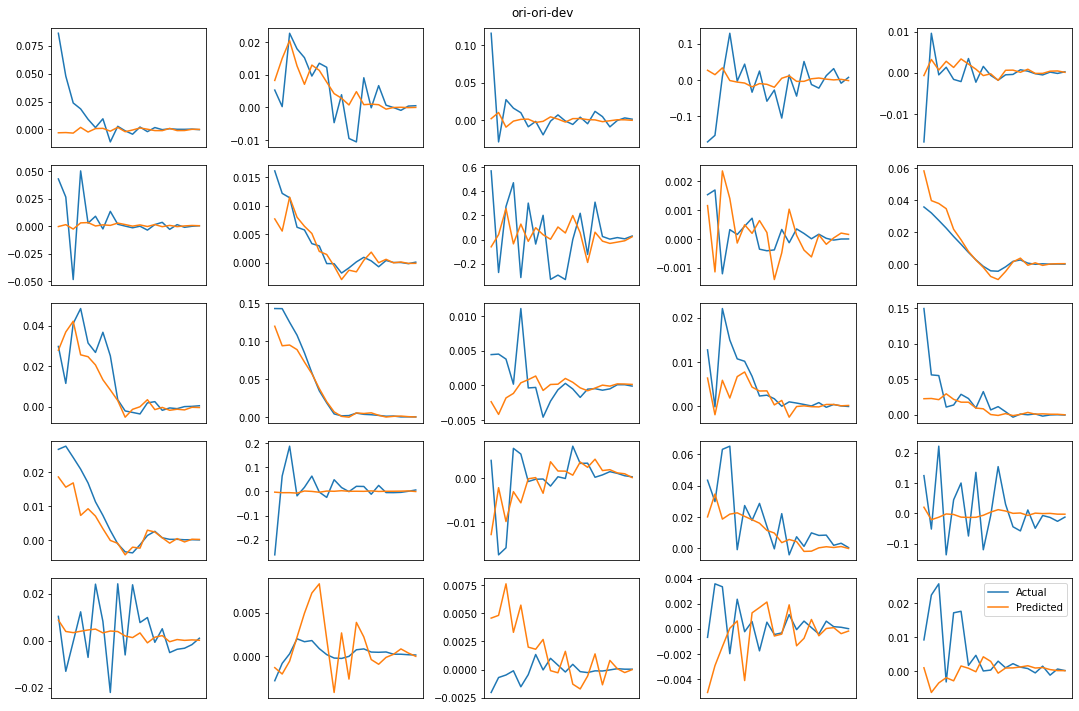

In [24]:
prediction3_dev = outputs_dev[:, 2, :]*dm1
prediction3_dev /= r13
evaluation.plot_55(prediction3_dev, dev_out3, 'ori-ori-dev')

[ 3.0363038  4.4785347  4.542575   5.50724    4.697218   5.271531
  5.165305  10.710664  20.350657   6.95111    5.005623   6.1609216
  7.4596605  7.293298  34.93208    8.323543   8.811514  10.145178
 12.828883  18.119612 ]
9.489573


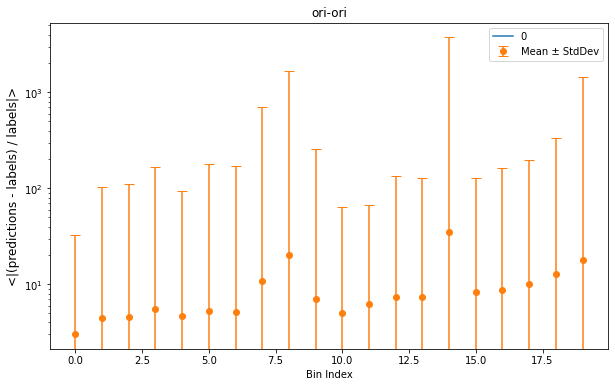

In [30]:
plot_AAPD(prediction3_dev, dev_out3, 'ori-ori')